# Práctica 9 - Descenso por gradiente y Redes Neuronales

Para realizar esta guía de ejercicios, descargar de la página de la materia el archivo $\texttt{tf\_regressor.py}$ para poder correr el comando:

In [1]:
#pip install tensorflow

In [2]:
#pip install keras --upgrade

In [3]:
from tf_regressor import Regressor, train_test_split_scale_center

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib import cm
from formulaic import Formula
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from time import time

## Ejercicio 1

En este ejercicio utilizaremos el dataset $\texttt{casos\_coronavirus}$

### Inciso a

Cargar el dataset y añadirle la columna $\texttt{dias\_transcurridos}$ con el índice de cada observación

In [5]:
coronavirus = pd.read_csv('../../datos/casos_coronavirus.csv')

In [6]:
coronavirus['dias_transcurridos'] = coronavirus.index
coronavirus

fecha  confirmados_Nuevos  dias_transcurridos
0   3-3-2020                   1                   0
1   4-3-2020                   0                   1
2   5-3-2020                   1                   2
3   6-3-2020                   6                   3
4   7-3-2020                   0                   4
..       ...                 ...                 ...
91  2-6-2020                 904                  91
92  3-6-2020                 949                  92
93  4-6-2020                 929                  93
94  5-6-2020                 840                  94
95  6-6-2020                 983                  95

[96 rows x 3 columns]

### Inciso b

Plotear $\texttt{dias\_transcurridos}$ vs. $\texttt{confirmados\_Nuevos}$

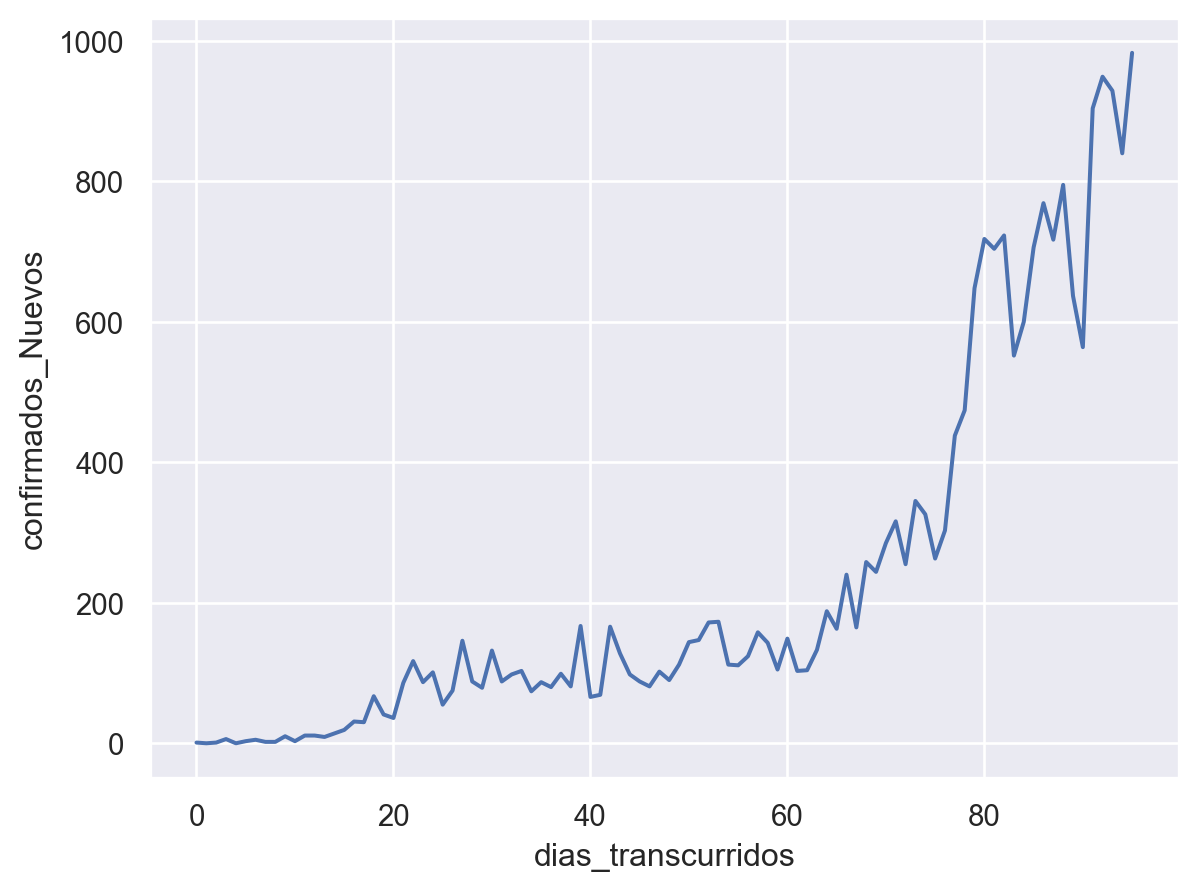

In [7]:
(
    so.Plot(data=coronavirus,x="dias_transcurridos",y="confirmados_Nuevos")
    .add(so.Line())
)

### Inciso c

Queremos armar un modelo de regresión que permita explicar la evolución de casos de coronavirus ($Y$) en función de los días transcurridos ($X$). Para esto se proponen los siguientes modelos:

i. $Y = b+w_0 x + w_1 X^2$

ii. $Y = b + w_0 X^{w_1}$

iii. $Y = b + we^{X}$

iv. $Y = b + w_0 e^{w_1 X}$

Dividir el conjunto de datos en entrenamiento y testeo y decidir qué modelo resulta más adecudado. Utilizar $\texttt{scikit-learn}$ para los modelos lineales y $\texttt{Regressor}$ para los no lineales. En este último caso, se pueden usar de guía los modelos lineales para establecer valores iniciales de los pesos. Probar con distintas cantidades de épocas y valores iniciales para los pesos y el bias.

**Obs:** para el modelo iv. escribir $\texttt{f}$ utilizando $\texttt{np.e**(w[1]*x)}$ para $e^{w_1 X}$ 

Comencemos observando que los modelos lineales (respecto a el bias $b$ y los weigths $w_i$) son el i. y el iii.

In [11]:
df_train,df_test = train_test_split(coronavirus,test_size=0.2,random_state=42)

#### Modelo 1

$Y = b+w_0 x+w_1 x^2$

In [31]:
formula1 = "confirmados_Nuevos ~ poly(dias_transcurridos,degree=2)"
y1_train, X1_train = Formula(formula1).get_model_matrix(df_train)
y1_test, X1_test = Formula(formula1).get_model_matrix(df_test)

modelo1 = linear_model.LinearRegression()
modelo1.fit(X1_train,y1_train)

y1_pred = modelo1.predict(X1_test)

MSE1 = mean_squared_error(y1_test,y1_pred)
print("Error cuadrático medio para el Modelo 1: ",MSE1)

Error cuadrático medio para el Modelo 1:  66152.4468750931


Ahora voy a hacerlo con $\texttt{tf\_regressor}$, para practicar.

In [34]:
f1 = lambda x, w, b : b + w[0]*x + w[1] * x**2

In [37]:
def ver_perdida(f,X_train,X_test,y_train,y_test):
    # Inicializamos el modelo (por ahora no tiene nada)
    model = Regressor()
    
    # Le agregamos la funcion y especificamos la dimension de w 
    model.add_f(f,                  # funcion del modelo 
                dim_w=2,            # dimension de w
                random_state=42,    # semilla para selecciones aleatorias
                opt='gd'            # Especificamos que usamos descenso por gradiente
                )
    
    # Entrenamos el modelo con los conjuntos de entrenamiento
    model.fit_(X_train, y_train,# Conjuntos de entrenamiento 
               verbose=0,
               epochs=200,              # Cantidad de epocas
               validation_split=0.2,    # 20% de datos para validacion
               learning_rate=0.05)      # Learning rate inicial 

    # Evaluamos el MSE en el conjunto de testeo
    return model.evaluate(X_test.to_numpy(), y_test.to_numpy(),        # A TensorFlow no le gustan los DataFrame de pandas 
                   return_dict=True,                            # Devuelve un diccionario (por si usamos mas de una métrica)
                   verbose=0,                                   # No imprima en pantalla el procedimiento de evaluación
                   batch_size=len(y_test))


In [44]:
ver_perdida(f1,X1_train,X1_test,y1_train,y1_test)

{'loss': 65143.1640625}

In [45]:
ver_perdida(f1,X_train,X_test,y_train,y_test)

{'loss': 0.022315165027976036}

<font color="red"><b>WHAT? PREGUNTAR

Nos dan errores muy parecidos

#### Modelo 2

$Y = b + w_0 X^{w_1}$

In [39]:
f2 = lambda x, w, b: b+ w[0] * x**w[1]

In [41]:
X = coronavirus['confirmados_Nuevos']
y = coronavirus['dias_transcurridos']

In [42]:
X_train, X_test, y_train, y_test = train_test_split_scale_center(X, y, 
                                                                 transform_y=True,  # Normalizamos y también 
                                                                 center=False,      # No centramos los datos
                                                                 test_size=0.2,     # 20% de los datos para testeo
                                                                 random_state=11)   # Semilla para datos de testeo